## Conformal Prediction on CIFAR10

Importing necessary libraries


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
try:
    from astra.torch.data import load_cifar_10
    from astra.torch.utils import train_fn
    from astra.torch.models import ResNetClassifier, EfficientNetClassifier
except:
    %pip install git+https://github.com/sustainability-lab/ASTRA
    from astra.torch.data import load_cifar_10
    from astra.torch.utils import train_fn
    from astra.torch.models import ResNetClassifier, EfficientNetClassifier

/home/vannsh.jani/miniconda3/lib/python3.11/site-packages/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /home/vannsh.jani/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


Dataset

In [2]:
dataset = load_cifar_10()
dataset

Files already downloaded and verified
Files already downloaded and verified



CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
range of image values: min=0.0, max=1.0
            

In [3]:
features = dataset.data
targets = dataset.targets
features.shape, targets.shape

(torch.Size([60000, 3, 32, 32]), torch.Size([60000]))

One vs rest setting (Active class = 2)

In [4]:
print(targets[:10])
targets_temp = torch.where(targets !=2, 0, targets)
targets = torch.where(targets_temp ==2, 1, targets_temp)
print(targets[:10])

tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])
tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])


Splittling Data into train, test and callibration set

In [5]:
X_train_cal, X_test, y_train_cal, y_test = train_test_split(features, targets, test_size=2/3, random_state=42)
X_train, X_cal, y_train, y_cal = train_test_split(X_train_cal, y_train_cal, test_size=0.5, random_state=42)
X_train.shape, X_cal.shape, X_test.shape

(torch.Size([10000, 3, 32, 32]),
 torch.Size([10000, 3, 32, 32]),
 torch.Size([40000, 3, 32, 32]))

Training

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
models = {"efficientnet": EfficientNetClassifier(n_classes=2), "resnet": ResNetClassifier(n_classes=2)}
for name, model in models.items():
    print(f"Training {name}...")
    epoch_loss,iter_loss = train_fn(model.to(device), nn.CrossEntropyLoss(), X_train, y_train, lr=1e-3, batch_size=1024, epochs=20)
    # model.to("cpu")
    
    

Training efficientnet...


Loss: 0.01442743: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


Training resnet...


Loss: 0.00419181: 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Evaluation

In [8]:
def results(y_test,y_pred):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='binary')
    rec = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    return [acc, prec, rec, f1]
    
def tabulate_results(result_dict):
    df = pd.DataFrame(result_dict)
    df.index = ['Accuracy', 'Precision', 'Recall', 'F1']
    return df

def softmax(y_pred):
    return torch.exp(y_pred)/torch.sum(torch.exp(y_pred), dim=1, keepdim=True)

In [9]:
result_dict = {}
predictions = {}
labels = {}
with torch.no_grad():
    for name, model in models.items():
        pred_y = model.predict(X_test, batch_size=1024).cpu()
        prediction_prob = softmax(pred_y)
        predicted_labels = torch.argmax(prediction_prob, dim=1)
        result_dict[name] = results(y_test, predicted_labels)
        predictions[name] = prediction_prob
        labels[name] = predicted_labels

    

df = tabulate_results(result_dict)
df

100%|██████████| 40/40 [00:00<00:00, 104.99it/s]


,efficientnet,resnet
Accuracy,0.922325,0.941250
Precision,0.664736,0.796725
Recall,0.457058,0.557132
F1,0.541673,0.655728


Looking at some predictions

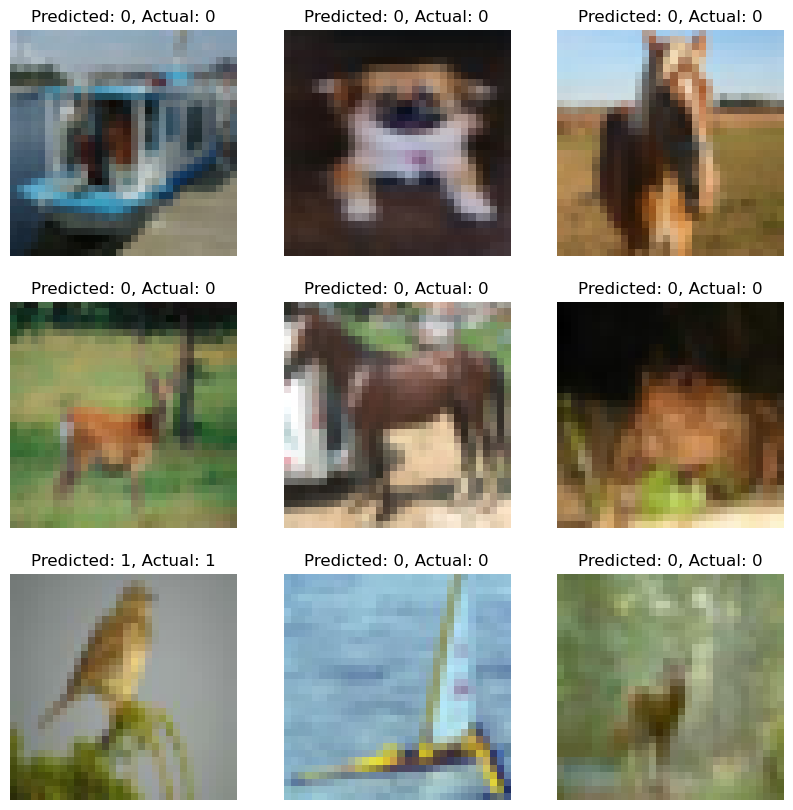

In [10]:
indices = np.random.randint(0, len(X_test), (9,))
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for ax, idx in zip(axes.ravel(),indices):
    ax.imshow(torch.einsum("chw->hwc", X_test[idx]))
    ax.set_title(f"Predicted: {predicted_labels[idx]}, Actual: {y_test[idx]}")
    ax.axis("off")

### Applying Conformal Prediction

Calculating conformity scores

In [11]:
conformity_scores = {}
def conformity_score(y_pred,y_true):
    scores = softmax(y_pred)
    return 1 - torch.where(y_true==0, scores[:,0], scores[:,1])  # 1 - softmax score for true class

with torch.no_grad():
    for name, model in models.items():
        y_pred_cal = model.predict(X_cal, batch_size=1024).cpu()
        conformity_scores[name] = conformity_score(y_pred_cal, y_cal)

conformity_scores["efficientnet"].shape, conformity_scores["resnet"].shape

    

100%|██████████| 10/10 [00:00<00:00, 119.48it/s]


(torch.Size([10000]), torch.Size([10000]))

Choosing error rate $\alpha=0.05$.Hence, $\text P(\text Y_{\text {n+1}}\hspace{0.01cm}\in \hspace{0.01cm}\hat{\text C}(\text X_{\text n+1}))\hspace{0.01cm} \gt \hspace{0.01cm} 1-\alpha$. The probability that the prediction set contains the true class is atleast 0.95.

In [12]:
# alpha_values = torch.arange(0.1,1,0.1)
# alpha_values

In [13]:
n = X_cal.shape[0] # calibration samples
def calculate_threshold(conformity_scores,n,alpha=0.05):
    thresholds = {}
    thresholds["efficientnet"] = {}
    thresholds["resnet"] = {}
    a = torch.ceil(torch.tensor((1-alpha)*(n+1))).item()/n
    mask = y_cal==0
    for name, scores in conformity_scores.items():
        thresholds[name]["0"] = (1 - torch.quantile(scores[mask], a)).item()
    mask = y_cal==1
    for name, scores in conformity_scores.items():
        thresholds[name]["1"] = (1 - torch.quantile(scores[mask], a)).item()
    return thresholds

thresholds_05 = calculate_threshold(conformity_scores,n,alpha=0.55) 
thresholds_05


{'efficientnet': {'0': 0.9999988675117493, '1': 0.5337094068527222},
 'resnet': {'0': 0.9999869465827942, '1': 0.9857370853424072}}

In [14]:
# alpha_thresholds = {}
# for alpha in alpha_values:
#     alpha_thresholds[np.round(alpha.item(),1)] = calculate_threshold(conformity_scores,n,alpha=np.round(alpha.item(),1))
# alpha_thresholds

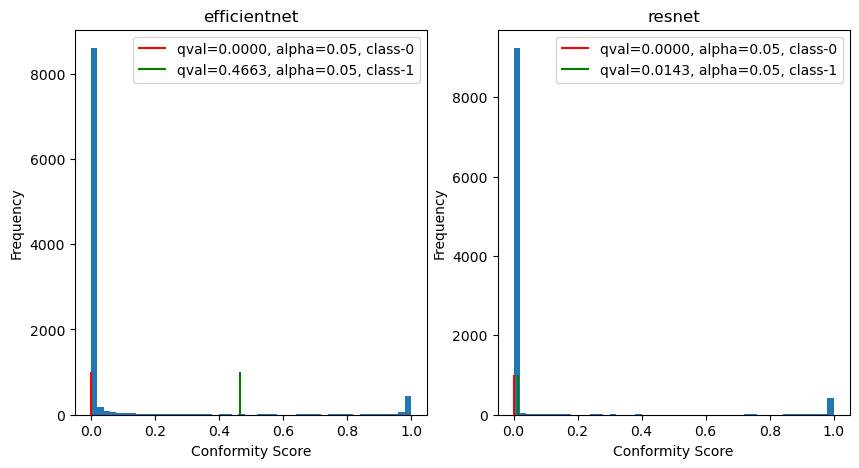

In [15]:
# plotting bar plots of scores and vlines for 1-threshold
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax, (name, scores) in zip(axes.ravel(), conformity_scores.items()):
    ax.hist(scores.detach().numpy(), bins=50)
    ax.vlines(1-thresholds_05[name]["0"], 0, 1000, color="red", label=f"qval={1-thresholds_05[name]['0']:.4f}, alpha=0.05, class-0")
    ax.vlines(1-thresholds_05[name]["1"], 0, 1000, color="green",label=f"qval={1-thresholds_05[name]['1']:.4f}, alpha=0.05, class-1")
    ax.legend()
    ax.set_title(name)
    ax.set_xlabel("Conformity Score")
    ax.set_ylabel("Frequency")

Finding out uncertain model predictions (both classes above threshold) and setting them as class 0.

In [16]:
def mod_pred(thresholds=thresholds_05,reduce_support=False):
   pred_set = {}
   for name,pred in predictions.items():
      class_0 = torch.where(pred[:,0]<thresholds_05[name]['0'], False, True) # if softmax score below threshold, then False else True for class 0
      class_1 = torch.where(pred[:,1]<thresholds_05[name]['1'], False, True) # if softmax score below threshold, then False else True for class 1
      pred_set[name] = torch.stack((class_0,class_1),dim=1)
      
   # modifying predictions
   indices = {}
   modified_predictions = {}
   for name,pred in pred_set.items():
      indices[name] = torch.any(pred!=False,dim=1)
      if reduce_support:
         pred = pred[indices[name]]
      modified_predictions[name] = torch.where((pred[:,0] == True) & (pred[:,1] == True), 1, torch.where((pred[:,0] == False) & (pred[:,1] == False), 0, torch.where(pred[:,0] == True, 0, 1)))
   return modified_predictions,pred_set,indices

modified_predictions,pred_set,indices = mod_pred(reduce_support=True)
indices["efficientnet"].shape, indices["resnet"].shape,modified_predictions["efficientnet"].shape, modified_predictions["resnet"].shape

(torch.Size([40000]),
 torch.Size([40000]),
 torch.Size([19518]),
 torch.Size([18483]))

In [17]:
# alpha_modified_predictions = {}
# alpha_pred_set = {}
# alpha_indices = {}
# for alpha in alpha_values:
#     alpha_modified_predictions[np.round(alpha.item(),1)],alpha_pred_set[np.round(alpha.item(),1)],alpha_indices[np.round(alpha.item(),1)] = mod_pred(alpha_thresholds[np.round(alpha.item(),1)],reduce_support=True)

In [18]:
def calc_results(modified_predictions,y_test,reduce_support=False):
    result_dict = {}
    y_test_original = y_test 
    for name in modified_predictions.keys():
        if reduce_support:
            y_test = y_test[indices[name]]
        result_dict[name] = results(y_test, modified_predictions[name])
        y_test = y_test_original
    return result_dict

result_dict2 = calc_results(modified_predictions,y_test,reduce_support=True)

# alpha_result_dict = {}
# for alpha in alpha_values:
#     alpha_result_dict[np.round(alpha.item(),1)] = calc_results(alpha_modified_predictions[np.round(alpha.item(),1)],y_test,reduce_support=True)


# for alpha in alpha_values:
#     print(f"alpha = {np.round(alpha,1)}")
#     print(tabulate_results(alpha_result_dict[np.round(alpha.item(),1)]))
#     print("\n")
df = tabulate_results(result_dict2)
df

,efficientnet,resnet
Accuracy,0.940312,0.978142
Precision,0.671852,0.883300
Recall,0.866699,0.910788
F1,0.756937,0.896834


In [19]:
for name,pred in pred_set.items():
    print("Number of images with both classes above threshold:",name,"=",(torch.where((pred[:,0] == True) & (pred[:,1] == True))[0].shape)[0])
    print("Number of images with both classes below threshold(model is uncertain):",name,"=",(torch.where((pred[:,0] == False) & (pred[:,1] == False))[0].shape)[0])

Number of images with both classes above threshold: efficientnet = 0
Number of images with both classes below threshold(model is uncertain): efficientnet = 20482
Number of images with both classes above threshold: resnet = 0
Number of images with both classes below threshold(model is uncertain): resnet = 21517
